# Quality of the data in general


Here I plot graphs of peak I and FWHM variations for different cycles. All data were reduced using the SPHERE DC without normalisation (which is useful for this case and will be performed later). Works for all ZIMPOL data reduced with individual cycles.

Aperture polarimetry



In [1]:
!pip install opencv-python

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from matplotlib.patches import Ellipse
import cv2
import math
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib.ticker import ScalarFormatter

In [17]:
def load_and_make_polar(dirdat,camera):
    dir = dirdat                                                        # define the data directory
    qfile = '*sci'+camera+'.fits'                                       # define formal we expect
    files = os.listdir(dir)                                             # list all files in this directory
    for file in files:
        if fnmatch.fnmatch(file, qfile):                                # if the string pattern matches
            hdulq = fits.open(dir + file)                               # open the file
            # define polarisation variables
            iq = hdulq[0].data[0]                                       # stokes i
            q = hdulq[0].data[1]                                        # stokes q
            iu = hdulq[0].data[2]                                       # stokes i
            u = hdulq[0].data[3]                                        # stokes u
            n=q.shape[0]
            # creating grid
            xr = np.linspace(-n/2, n/2, num=n)
            yr = np.linspace(-n/2, n/2, num=n)
            x0 = 0.5
            y0 = 0.5
            xr = xr-x0
            yr = yr-y0
            Xr, Yr = np.meshgrid(xr, yr)

            # calculate other relevant parameters
            R = np.sqrt(Xr**2 + Yr**2)                                  # radial distance
            phi = np.arctan(Yr/Xr)                                      # azimuthal angle
            i=(iq+iu)/2                                                 # average intensity
            q_phi=q*np.cos(2*phi)+u*np.sin(2*phi)                       # q_phi calculation
            # q_phi = (q_phi > 0)*q_phi +  (q_phi <=0 )*1e-10             # ensures q_phi is positive
            u_phi=q*np.sin(2*phi)+u*np.cos(2*phi)                       # u_phi calculation
            pi=np.sqrt(q*q+u*u)                                         # polarised intensity
            aolp=0.5*np.arctan2(u, q)+np.pi/2                           # angle of linear polarisation

    return iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi

def load_and_make_polar_umon(dirdat,cycle,camera):
    #q
    dir = dirdat+'q_corr/'
    qfile = '*_'+str(cycle)+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            q = hdulq[0].data
            n=q.shape[0]
    #u
    dir = dirdat+'u_corr/'
    qfile = '*_'+str(cycle)+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            u = hdulq[0].data
    #qphi
    dir = dirdat+'qphi_corr/'
    qfile = '*_'+str(cycle)+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            qphi = hdulq[0].data
            
    #uphi
    dir = dirdat+'uphi_corr/'
    qfile = '*_'+str(cycle)+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            uphi = hdulq[0].data
            
            
            
    #iq,iu
    dir = dirdat+'sci/'
    qfile = '*_'+str(cycle)+'_'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            iu = hdulq[0].data[2]
             #Creating grid
            xr = np.linspace(-n/2, n/2, num=n)
            yr = np.linspace(-n/2, n/2, num=n)
            x0 = 0.5
            y0 = 0.5
            xr = xr-x0
            yr = yr-y0
            Xr, Yr = np.meshgrid(xr, yr)
            R = np.sqrt(Xr**2 + Yr**2)
            phi = np.arctan(Yr/Xr)
            
            i=(iq+iu)/2
            
            # qphi = (qphi > 0)*qphi +  (qphi <=0 )*1e-10
            qphi = qphi
            pi=np.sqrt(q*q+u*u)
            aolp=0.5*np.arctan2(u, q)+np.pi/2
            
    return iq,q,iu,u,i,qphi,uphi,pi,aolp,R,phi

def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")

def create_dir(dirname):
    if not os.path.isdir(dirname):
        os.makedirs(dirname, exist_ok=True)
    return dirname
        
def maskcrit(aolp,R):
    phi = (aolp-90)                                                                 # adjust reference frame
    n=aolp.shape[0]                                                                 # shape of first dimension
    critarray=np.zeros_like(phi)                                                    # create array of critical values

    # if phi at a pixel > 180 degrees, it subtracts 180 degrees – normalises the angle to a range within 0 to 180
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]>180:
                phi[ix,iy]=phi[ix,iy]-180
            
    for ix in range (2,n-2):
        for iy in range(2,n-2):
            if R[ix,iy]>=1:                                                             # if R is above certain threshold
                datapix=[]
                for (iix,iiy) in [(ix,iy),(ix-1,iy),(ix+1,iy),(ix,iy-1),(ix,iy+1)]:     # check current pixel value and immediate neighbours
                    if R[iix,iiy]>=1:
                        datapix.append(abs(phi[iix,iiy]))                               # add the absolute value to the datapix array
                crit=np.std(datapix)                                                    # calculate std. dev of all pixels
                critarray[ix,iy]=crit                                                   # assign this value to the crit array
                
    for ix in range (0,n-1):
        for iy in range(0,n-1):
            if critarray[ix,iy]==0:                                                     # if edge case of pixel 0
                critarray[ix,iy]=np.max(critarray)                                      # give non-zero value

    medianstd=np.nanmedian(critarray)                                                   # take the std of all non-NaN values
    mask=(critarray<=medianstd)#*R([ix,iy]>=1)                                          # return a mask of all values less than the std dev of the image

    return mask
        
def plot_AoLP(ps,R,Q,U,I,Q_PHI,PI,AOLP,title,save):
    # First, we plot the background image
    fig = plt.figure(figsize=(8,8))
    i_plot = fig.add_subplot(111)
    n = I.shape[0]
    d = n * ps / 2

    im1=i_plot.imshow(np.arcsinh(Q_PHI), origin='lower',extent=(-d, d, d, -d))

    fig.colorbar(im1, orientation='vertical')

    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.tight_layout(pad=0.1)     

    # ranges of the axis
    xx0, xx1 = i_plot.get_xlim()
    yy0, yy1 = i_plot.get_ylim()

    # binning factor
    factor = [4, 4]

    # re-binned number of points in each axis
    nx_new = PI.shape[1] // factor[0]
    ny_new = PI.shape[0] // factor[1]

    # These are the positions of the quivers
    X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                      np.linspace(yy0,yy1,ny_new,endpoint=True))
    # bin the data
    I_bin = I.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_bin = Q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    U_bin = U.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_phi_bin = Q_PHI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    PI_bin=PI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    R_bin=R.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    aolp_bin=AOLP.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)

    # polarization angle
    psi=0.5*np.arctan2(U_bin, Q_bin)

    #psi=aolp_bin
    #i_plot.imshow(psi, origin='lower',extent=(-d, d, d, -d))

    # polarization fraction
    frac =Q_phi_bin/I_bin
    #frac=dolp_v[adc:bdc,adc:bdc]
    # mask to show only alighned

    mask1=maskcrit(psi,R_bin)
    mask2=Q_phi_bin>=10
    mask=mask2#*mask1
    #print('max DoLP in region %.3f percent'%(np.max(frac[mask])*100))

    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    pixX = frac*np.cos(psi+np.pi/2) # X-vector 
    pixY = frac*np.sin(psi+np.pi/2) # Y-vector

    # keyword arguments for quiverplots
    quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
    i_plot.quiver(X[mask], Y[mask], pixX[mask], pixY[mask],scale=2, **quiveropts)
    plt.title(title)
    plt.savefig(save,bbox_inches='tight', pad_inches=0.1)
    #plt.show()#(dirName+"aolp.png",bbox_inches='tight', pad_inches=0.1)
    plt.close()
    
def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))

def find_FWHM (PSF,n,ps,figfolder,title):             #resolution
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))


    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])


    plt.plot(xdata, y1, 'o', label='vertical')
    plt.plot(xdata, gaus(xdata,*popt1), '-', label='fit1')
    plt.plot(xdata, y2, 'o', label='horizotal')
    plt.plot(xdata, gaus(xdata,*popt2), '-', label='fit2')
    plt.legend()
    plt.title(title)
    plt.savefig(figfolder+title+'.png',bbox_inches='tight', pad_inches=0.1)
    plt.close()

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2*ps

    return fwhm

def ap_fixed_in(rad,R,q,u,PSF):
    # aperture photometry
    mask = (R <= rad)                                                           # create a mask for when the radius is smaller than a set distance (coronial mask)
    q_sum = np.sum(q[mask])                                                     # sum all the q stokes
    u_sum = np.sum(u[mask])                                                     # sum all the u stokes
    psf_sum = np.sum(PSF[mask])                                                 # sum the point spread function
    q_i_percent = q_sum / psf_sum * 100                                         # calculate the percentage of q stokes relative to psf
    u_i_percent = u_sum / psf_sum * 100                                         # calculate the percentage of u stokes relative to psf

    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def ap(radin,radout,R,q,u,PSF):
    # aperture photometry
    mask = (R <= radout) * (R >= radin)                                         # create a mask for a set annulus ring (coronial mask)
    q_sum = np.sum(q[mask])                                                     # sum all the q stokes
    u_sum = np.sum(u[mask])                                                     # sum all the u stokes
    psf_sum = np.sum(PSF[mask])                                                 # sum the point spread function
    q_i_percent = q_sum / psf_sum * 100                                         # calculate the percentage of q stokes relative to psf
    u_i_percent = u_sum / psf_sum * 100                                         # calculate the percentage of u stokes relative to psf

    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

In [18]:
#star='IRAS08544-4431'  'HD83878'   'HD75885' 'AR_Pup'
#stars=['HR4049_20190108','HR4049_20190107','HR4226','HD71253','HD94680','HD96314','HD98025','V709_Car','HD75885', 'AR_Pup_dc_notnorm','UMon']

# target names you want to run script for, here input the name of the folder rather then the target star
stars=['01.SCI_AR_Pup']
stars=['REF_HD75885']
stars=['01.SCI_UMon']
stars=['REF_HD71253']
# proper target names for plot titles
starnames = {'01.SCI_UMon':'U Mon','01.SCI_AR_Pup':'AR Pup','REF_HD71253':'HD71253','REF_HD75885':"HD75885"}
fittypes=['1', '2'] # fittypes are the camera types in ZIMPOL (there are two cameras with different filters)

band=['V','I'] # corresponding filters that were used for data
ps=3.6 # mas/pixel resolution of ZIMPOL, different for IRDIS

In [19]:
starnames[stars[0]]

'HD71253'

## Aperture polarimetry and other characteristics for each frame in the sample

### Without correction of intrinsic polarisation

max DoLP in the region R>=1.5 and R<500/ps  (500 mas in radius)


In [20]:
for star in stars:
    # create folders for data and image outputs
    figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/'
    createfolder(figfolder)
    figfolder=figfolder+ 'Quality_indiv_cycles/'
    createfolder(figfolder)
    figfolder=figfolder+ 'no_unres_correction/'
    createfolder(figfolder)
    
    if star=='AR_Pup':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/AR_Pup/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_indiv_process_list.csv'

    elif star=='01.SCI_AR_Pup':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/AR_Pup/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'
    
    elif star=='01.SCI_UMon':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/UMon/'
        input_filename =dirdat+'process_list.csv'

    else:
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/'+starnames[star]+'/'
        input_filename =dirdat+'process_list.csv'
  
        
    table = pd.read_csv(input_filename)
    table['reference']= table['reference'].str.replace(' ', '_') # fix in case there are spaces in the name

    processes=table['id']

    reference={process:ref for process,ref in zip(table['id'], table['reference'])}

    print(reference)

    for fittype in fittypes:
        output_filename = figfolder+star+'_'+band[int(fittype)-1]+'_Original_AP_per_cycle.txt'
        with open(output_filename, 'w') as file_print:
            line="{:<30} {:<5} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}\n".format(
                'reference','cycle',"max_DoLP[%]", "max_Q_phi", "max_PI", "sumQ/I[%]", "sumQ_phi/I[%]","sumPI/I[%]",
                'FWHM','CNT60[%]','Peak_i(Strehl)','Peak_PI','peak_Q_Phi',
                '0-3_PSF', '0-3_Q', '0-3_U', '0-3_Q/I[%]', '0-3_U/I[%]',
                '0-5_PSF', '0-5_Q', '0-5_U', '0-5_Q/I[%]', '0-5_U/I[%]',
                '0-10_PSF', '0-10_Q', '0-10_U', '0-10_Q/I[%]', '0-10_U/I[%]',
                '0-50_PSF', '0-50_Q', '0-50_U', '0-50_Q/I[%]', '0-50_U/I[%]',
                '0-100_PSF', '0-100_Q', '0-100_U', '0-100_Q/I[%]', '0-100_U/I[%]',
                '1-3_PSF', '1-3_Q', '1-3_U', '1-3_Q/I[%]', '1-3_U/I[%]',
                '3-5_PSF', '3-5_Q', '3-5_U', '3-5_Q/I[%]', '3-5_U/I[%]',
                '3-30_PSF', '3-30_Q', '3-30_U', '3-30_Q/I[%]', '3-30_U/I[%]',
                '5-30_PSF', '5-30_Q', '5-30_U', '5-30_Q/I[%]', '5-30_U/I[%]')

            file_print.write(line)
          
            for process in processes:
                
                print(process)
                
                # if star=='01.SCI_UMon':
                #     dirName=dirdat
                    # iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar_umon(dirName,process,fittype)
                # else:
                dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
                iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)

                n=q.shape[0]
                if star=='01.SCI_AR_Pup':
                    lim=150       
                else:
                    lim=50       

                filename={0:'PI',1:'Q_phi', 2:"U_phi",3:'Q',4:'U',5:'I'}

                mask=(R<=500/ps)
                frac =np.max(np.divide(q_phi,i,where=i!=0)*(R<=500/ps)*(R>=1.5))*100            # find the fractional intensity (q_phi/total intesity) for a specific annulus
                q_sum=np.sum(q[mask])                                                           # sum all the q in this annulus
                qphi_sum=np.sum(q_phi[mask])                                                    # sum all the q_phi in this annulus
                I_sum=np.sum(i[mask])                                                           # sum all the intensity in this annulus
                pi_sum=np.sum(pi[mask])                                                         # sum the polarised intensity in this annulus

                # calculate FWHM
                fwhm=find_FWHM (i,n,ps,figfolder,band[int(fittype)-1]+'_gauss_'+reference[process])

                # normalise the image to the 10e6, may be useful for further comparison ZIMPOL with IRDIS
                mask=(R<=1500/ps)
                middle=int(n/2)
                ctn6=i*np.sum(i[mask])/10e6
                cnt60=np.max(ctn6[middle-1:middle+1,middle-1:middle+1])/10e6*100

                # calculating the ratio of peak brightness to the total
                # I: refers to the observational conditions and is a proxy of strehl ratio
                normalisation=np.sum(i[mask])
                peak_i=np.max(i*(R<200))/normalisation
                peak_pi=np.max(pi*(R<200))/normalisation
                peak_q_phi=np.max(q_phi*(R<200))/normalisation # might be less informative than PI because of unresolved signal in the center
                
                 # extracting cycle number from reference
                if star=='HD83878'  or star=='UMon_Katya' or star== 'REF_HD75885' or star== 'HD71253' or star=='HD94680' or star=='HD96314' or star=='HD98025' or star=='HR4226':
                    cycle_number=reference[process].split('_')[1][:-1]
                elif star=='01.SCI_UMon':
                    cycle_number=reference[process][3:]
                else:
                    cycle_number=reference[process].split('_')[2][:-1]

                # Aperture Photometry Calculation

                # calculate the PSF, Q, U, Q/PSF percentage, and U/PSF percentage for an image with a radial mask corresponding to n pixels
                psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3=ap_fixed_in(3,R,q,u,i)     
                psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5=ap_fixed_in(5,R,q,u,i)
                psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10=ap_fixed_in(10,R,q,u,i)            
                psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50=ap_fixed_in(50,R,q,u,i)            
                psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100=ap_fixed_in(100,R,q,u,i)            

                # calculate the PSF, Q, U, Q/PSF percentage, and U/PSF percentage for an image with an annulus mask corresponding to n - m pixels
                psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3=ap(1,3,R,q,u,i)
                psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5=ap(3,5,R,q,u,i)
                psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30=ap(5,30,R,q,u,i)
                psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30=ap(3,30,R,q,u,i)

                line = "{:<30} {:<5} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.6f} {:<15.8f} {:<15.8f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} \n".format(  \
                        reference[process],cycle_number, \
                        frac, np.max(q_phi), np.max(pi), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100, \
                        fwhm,cnt60,peak_i,peak_pi,peak_q_phi, \
                        psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3, \
                        psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5, \
                        psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10, \
                        psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50, \
                        psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100, \
                        psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3, \
                        psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5, \
                        psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30,  \
                        psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30)
                file_print.write(line)

                for fileindex,image1 in enumerate([pi,q_phi, u_phi,q,u,i]):
                    image_an = image1*(R<250)
                    image=np.arcsinh(image_an)
                    fig, ax = plt.subplots()
                    f.plottingroutinemas(image,lim,ps,n,star,ax)        
                    f.scale_mas(star,ax)  

                    plt.title(reference[process]+', '+filename[fileindex]+', '+band[int(fittype)-1]) 
                    plt.savefig(figfolder+band[int(fittype)-1]+'_'+filename[fileindex]+'_'+reference[process]+'.png',bbox_inches='tight', pad_inches=0.1)
                    plt.close()

{573463: 'HD71253_11c_06_12-13_not_norm', 573462: 'HD71253_9c_06_10-11_not_norm', 573461: 'HD71253_8c_06_08-10(1)_not_norm', 573460: 'HD71253_7c_06_06-08(1)_not_norm', 573459: 'HD71253_6c_06_04-06(1)_not_norm', 573458: 'HD71253_5c_06_02-04(1)_not_norm', 573457: 'HD71253_4c_06_01-02(1)_not_norm', 573456: 'HD71253_3c_05_59-00_not_norm', 573455: 'HD71253_2c_05_57-58_not_norm', 573454: 'HD71253_1c_05_55-56_not_norm'}
573463
573462
573461
573460
573459
573458
573457
573456
573455
573454
573463
573462
573461
573460
573459
573458
573457
573456
573455
573454


### Correction of the intrinsic polarisation


In [21]:
stars

['REF_HD71253']

In [22]:
# apertures for the calculation of unresolved polarisation signal
annuli=[3,5]#,10,200,270                                                            # annuli values
annuli_name={3:'0-3',5:'0-5',10:'0-10',200:'30-200',270:'100-200'}                  # annuli name (for plotting + folder creation)

for star in stars:
    figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/'
    createfolder(figfolder0)
    figfolder0=figfolder0+ 'Quality_indiv_cycles/'
    createfolder(figfolder0)

    if star=='AR_Pup':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/AR_Pup'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_indiv_process_list.csv'

    elif star=='01.SCI_AR_Pup':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/AR_Pup/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'

    elif star=='01.SCI_UMon':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/UMon/'
        input_filename =dirdat+'process_list.csv'

    else:
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/'+starnames[star]+'/'
        input_filename =dirdat+'process_list.csv'

    table = pd.read_csv(input_filename)
    table['reference']= table['reference'].str.replace(' ', '_') # fix in case there are spaces in the name

    processes=table['id']

    reference={process:ref for process,ref in zip(table['id'], table['reference'])}

    print(reference)
    for annulus in annuli:
        print(annuli_name[annulus])
        figfolder=figfolder0+ annuli_name[annulus]+'_unres_correction/'
        createfolder(figfolder)
        #figfolder=dirdat+'images_'+annuli_name[annulus]+'/'
        for fittype in fittypes:
            output_filename = figfolder0+star+'_'+annuli_name[annulus]+'_'+band[int(fittype)-1]+'_AP_per_cycle.txt'

            with open(output_filename, 'w') as file_print:
                line="{:<30} {:<5} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}\n".format(
                        'reference','cycle',"max_DoLP[%]", "max_Q_phi", "max_PI", "sumQ/I[%]", "sumQ_phi/I[%]","sumPI/I[%]",
                        'FWHM','CNT60[%]','Peak_i(Strehl)','Peak_PI','peak_Q_Phi',
                        '0-3_PSF', '0-3_Q', '0-3_U', '0-3_Q/I[%]', '0-3_U/I[%]',
                        '0-5_PSF', '0-5_Q', '0-5_U', '0-5_Q/I[%]', '0-5_U/I[%]',
                        '0-10_PSF', '0-10_Q', '0-10_U', '0-10_Q/I[%]', '0-10_U/I[%]',
                        '0-50_PSF', '0-50_Q', '0-50_U', '0-50_Q/I[%]', '0-50_U/I[%]',
                        '0-100_PSF', '0-100_Q', '0-100_U', '0-100_Q/I[%]', '0-100_U/I[%]',
                        '1-3_PSF', '1-3_Q', '1-3_U', '1-3_Q/I[%]', '1-3_U/I[%]',
                        '3-5_PSF', '3-5_Q', '3-5_U', '3-5_Q/I[%]', '3-5_U/I[%]',
                        '3-30_PSF', '3-30_Q', '3-30_U', '3-30_Q/I[%]', '3-30_U/I[%]',
                        '5-30_PSF', '5-30_Q', '5-30_U', '5-30_Q/I[%]', '5-30_U/I[%]')

                file_print.write(line)
                for process in processes:

                    print(reference[process])

                    if star=='UMon':
                        dirName=dirdat
                        iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar_umon(dirName,process,fittype)
                    else:
                        dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
                        iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)

                    n=q.shape[0]

                    # creating grid
                    if star=='AR_Pup':
                        lim=150
                    else:
                        lim=50

                    # correction for the unresolved polarisation, based on annulus radius
                    correction_radius=annulus
                    if annulus==200:
                        mask=(R<=correction_radius)*(R>=30)
                    if annulus==270:
                        mask=(R<=200)*(R>=100)
                    else:
                        mask=(R<=correction_radius)

                    q_over_i=np.divide(q,i,where=i!=0)                      # calculate fraction of Q/total intensity (normalisation)
                    cq=np.median(q_over_i[mask])                            # for median normal as in IRDIS
                    u_over_i=np.divide(u,i,where=i!=0)                      # calculate fraction of U/total intensity (normalisation)
                    cu=np.median(u_over_i[mask])                            # for median normal as in IRDIS

                    q_corr=q-cq*iq                                          # calculate corrected Q by subtracting median
                    u_corr=u-cu*iu                                          # calculate corrected U by subtracting median
                    # recalculate corrected stokes parameters
                    q_phi_corr=q_corr*np.cos(2*phi)+u_corr*np.sin(2*phi)                        # Q phi
                    # q_phi_corr=(q_phi_corr> 0)*q_phi_corr + (q_phi_corr <=0 )*1e-10             # make Q phi positive
                    u_phi_corr=q_corr*np.sin(2*phi)+u_corr*np.cos(2*phi)                        # U phi
                    pi_corr=np.sqrt(q_corr*q_corr+u_corr*u_corr)                                # polarised intensity
                    aolp_corr=0.5*np.arctan2(u_corr, q_corr)+np.pi/2                            # angle of linear polarisation
                    angleofpol=np.rad2deg(0.5*np.arctan2(cu, cq))                               # calculated in degrees
                    if angleofpol<0: angleofpol+=180                                            # make positive

                    frac =np.max(np.divide(q_phi_corr,i,where=i!=0)*(R<=500/ps)*(R>1.5))*100
                    mask=(R<=500/ps)
                    q_sum=np.sum(q_corr[mask])
                    qphi_sum=np.sum(q_phi_corr[mask])
                    I_sum=np.sum(i[mask])
                    pi_sum=np.sum(pi_corr[mask])

                    # calculate FWHM
                    fwhm=find_FWHM (i,n,ps,figfolder,band[int(fittype)-1]+'_gauss_'+reference[process])
                    # normalise the image to the 10e6,may be useful for further comparison ZIMPOL with IRDIS
                    mask=(R<=1500/ps)
                    middle=int(n/2)
                    ctn6=i*np.sum(i[mask])/10e6
                    cnt60=np.max(ctn6[middle-1:middle+1,middle-1:middle+1])/10e6*100

                    # calculating what is the ratio of peak brightness to the total in 3'' aperture. For I it refers to the observational conditions and is a proxy of strehl ratio
                    normalisation=np.sum(i[mask])
                    peak_i=np.max(i*(R<500/ps))/normalisation
                    peak_pi=np.max(pi_corr*(R<500/ps))/normalisation
                    peak_q_phi=np.max(q_phi_corr*(R<500/ps))/normalisation # might be less informative than PI because of unresolved signal in the center

                    # extracting cycle number from reference
                    if star=='HD83878' or star=='UMon_Katya' or star== 'REF_HD75885' or star== 'HD71253' or star=='HD94680' or star=='HD96314' or star=='HD98025' or star=='HR4226':
                        cycle_number=reference[process].split('_')[1][:-1]
                    elif star=='UMon':
                        cycle_number=reference[process][3:]
                    else:
                        cycle_number=reference[process].split('_')[2][:-1]
                    psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3=ap_fixed_in(3,R,q_corr,u_corr,i)
                    psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5=ap_fixed_in(5,R,q_corr,u_corr,i)
                    psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10=ap_fixed_in(10,R,q_corr,u_corr,i)
                    psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50=ap_fixed_in(50,R,q_corr,u_corr,i)
                    psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100=ap_fixed_in(100,R,q_corr,u_corr,i)

                    psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3=ap(1,3,R,q_corr,u_corr,i)
                    psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5=ap(3,5,R,q_corr,u_corr,i)
                    psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30=ap(5,30,R,q_corr,u_corr,i)
                    psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30=ap(3,30,R,q_corr,u_corr,i)



                    line = "{:<30} {:<5} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.6f} {:<15.8f} {:<15.8f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}  {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f} \n".format(  \
                        reference[process],cycle_number, \
                        frac, np.max(q_phi_corr), np.max(pi_corr), q_sum/I_sum*100, qphi_sum/I_sum*100, pi_sum/I_sum*100, \
                        fwhm,cnt60,peak_i,peak_pi,peak_q_phi, \
                        psf_sum3, q_sum3, u_sum3, q_i_percent3, u_i_percent3, \
                        psf_sum5, q_sum5, u_sum5, q_i_percent5, u_i_percent5, \
                        psf_sum10, q_sum10, u_sum10, q_i_percent10, u_i_percent10, \
                        psf_sum50, q_sum50, u_sum50, q_i_percent50, u_i_percent50, \
                        psf_sum100, q_sum100, u_sum100, q_i_percent100, u_i_percent100, \
                        psf_sum1_3, q_sum1_3, u_sum1_3, q_i_percent1_3, u_i_percent1_3, \
                        psf_sum3_5, q_sum3_5, u_sum3_5, q_i_percent3_5, u_i_percent3_5, \
                        psf_sum3_30, q_sum3_30, u_sum3_30, q_i_percent3_30, u_i_percent3_30,  \
                        psf_sum5_30, q_sum5_30, u_sum5_30, q_i_percent5_30, u_i_percent5_30)


                    file_print.write(line)

                    # plotting
                    filename={0:'Q_phi_corr',1:'U_phi_corr',2:'PI_corr'}

                    for fileindex,image1 in enumerate([q_phi_corr,u_phi_corr,pi_corr]):
                        image_an = image1*(R<250)
                        image=np.arcsinh(image_an)
                        fig, ax = plt.subplots()
                        f.plottingroutinemas(image,lim,ps,n,star,ax)
                        f.scale_mas(star,ax)

                        plt.title(reference[process]+', '+filename[fileindex]+', '+annuli_name[annulus]+', '+band[int(fittype)-1])
                        plt.savefig(figfolder+band[int(fittype)-1]+'_'+filename[fileindex]+'_'+reference[process]+'.png',bbox_inches='tight', pad_inches=0.1)
                        #plt.show()
                        plt.close()
                    adc=int(440)
                    bdc=int(n-440)

                    title=reference[process]+', '+'AoLP'+', '+annuli_name[annulus]+', '+band[int(fittype)-1]

                    save=figfolder+band[int(fittype)-1]+'_aolp_'+reference[process]+'.png'
                    plot_AoLP(ps,R[adc:bdc,adc:bdc],q_corr[adc:bdc,adc:bdc],u_corr[adc:bdc,adc:bdc],i[adc:bdc,adc:bdc],q_phi_corr[adc:bdc,adc:bdc],pi_corr[adc:bdc,adc:bdc],aolp_corr[adc:bdc,adc:bdc],title,save)



{573463: 'HD71253_11c_06_12-13_not_norm', 573462: 'HD71253_9c_06_10-11_not_norm', 573461: 'HD71253_8c_06_08-10(1)_not_norm', 573460: 'HD71253_7c_06_06-08(1)_not_norm', 573459: 'HD71253_6c_06_04-06(1)_not_norm', 573458: 'HD71253_5c_06_02-04(1)_not_norm', 573457: 'HD71253_4c_06_01-02(1)_not_norm', 573456: 'HD71253_3c_05_59-00_not_norm', 573455: 'HD71253_2c_05_57-58_not_norm', 573454: 'HD71253_1c_05_55-56_not_norm'}
0-3
HD71253_11c_06_12-13_not_norm
HD71253_9c_06_10-11_not_norm
HD71253_8c_06_08-10(1)_not_norm
HD71253_7c_06_06-08(1)_not_norm
HD71253_6c_06_04-06(1)_not_norm
HD71253_5c_06_02-04(1)_not_norm
HD71253_4c_06_01-02(1)_not_norm
HD71253_3c_05_59-00_not_norm
HD71253_2c_05_57-58_not_norm
HD71253_1c_05_55-56_not_norm
HD71253_11c_06_12-13_not_norm
HD71253_9c_06_10-11_not_norm
HD71253_8c_06_08-10(1)_not_norm
HD71253_7c_06_06-08(1)_not_norm
HD71253_6c_06_04-06(1)_not_norm
HD71253_5c_06_02-04(1)_not_norm
HD71253_4c_06_01-02(1)_not_norm
HD71253_3c_05_59-00_not_norm
HD71253_2c_05_57-58_not

### Creating images

<>:159: SyntaxWarning: invalid escape sequence '\p'
<>:159: SyntaxWarning: invalid escape sequence '\p'
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_74542/3774740120.py:159: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('$Q_{\phi}/I_{tot}$', fontsize=18)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_74542/3774740120.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_74542/3774740120.py:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_74542/3774740120.py:35: FutureWarning: The 'delim_whitespace' keyword in pd.rea

Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/REF_HD71253/Quality_indiv_cycles/  already exists
                         reference  cycle  max_DoLP[%]  max_Q_phi  max_PI  \
0    HD71253_11c_06_12-13_not_norm      0       10.906     57.136  64.266   
1     HD71253_9c_06_10-11_not_norm      0        6.227     50.116  81.598   
2  HD71253_8c_06_08-10(1)_not_norm      0        4.976     49.287  59.294   
3  HD71253_7c_06_06-08(1)_not_norm      0        4.986     50.568  61.734   
4  HD71253_6c_06_04-06(1)_not_norm      0        4.689     52.349  70.579   

   sumQ/I[%]  sumQ_phi/I[%]  sumPI/I[%]    FWHM  CNT60[%]  ...     3-30_PSF  \
0     -0.072          0.025       0.730  29.314     0.100  ...  1710705.000   
1     -0.115         -0.010       0.726  29.518     0.092  ...  1626180.500   
2     -0.099          0.021       0.669  30.661     0.094  ...  1714398.375   
3     -0.121          0.017       0.667  31.503     0.088  ...  1717438.500   
4     -0.151          

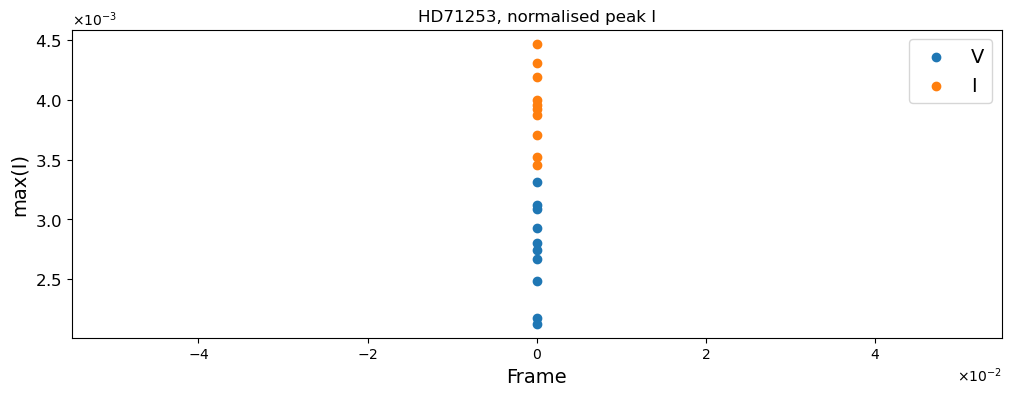

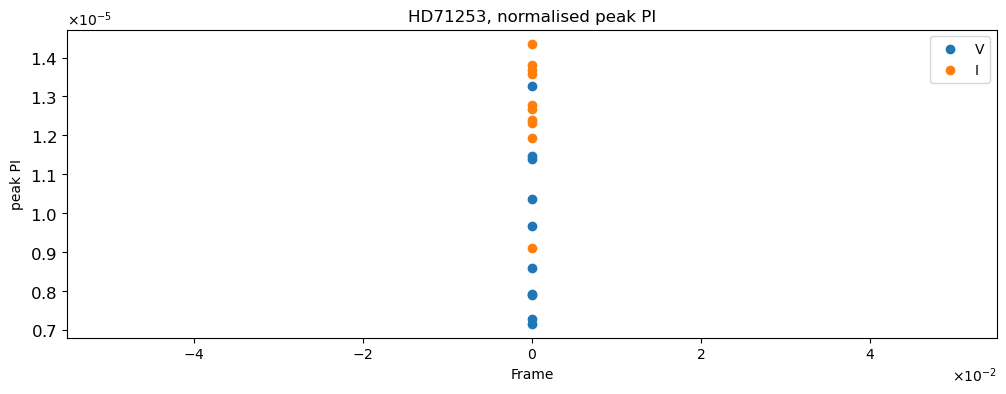

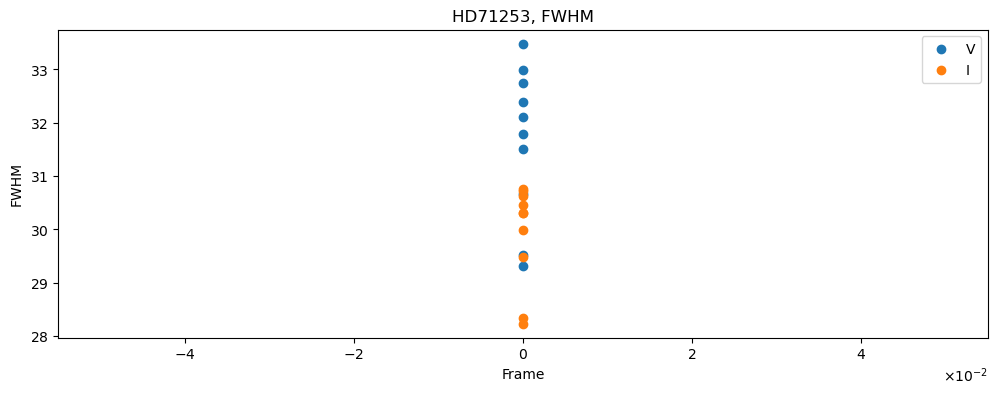

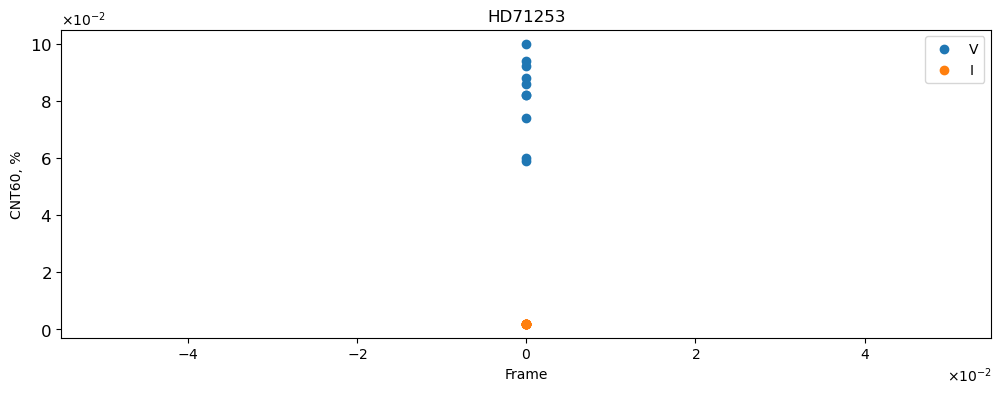

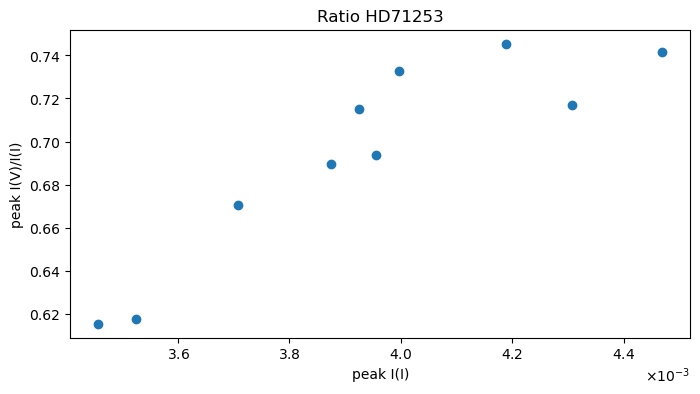

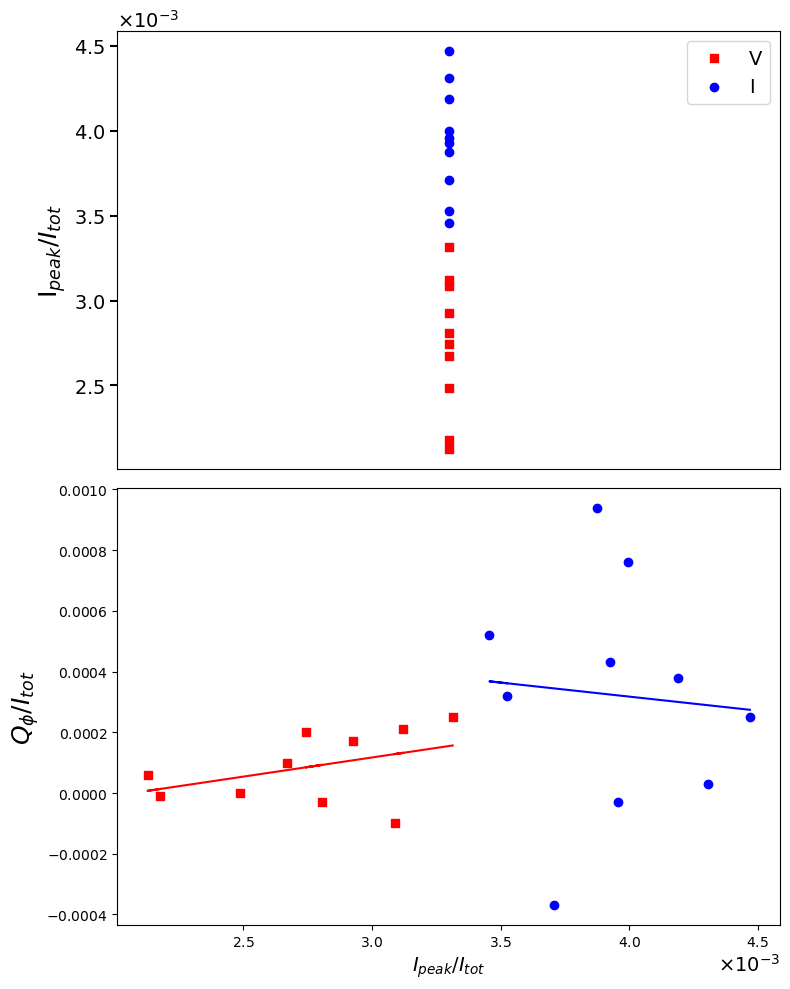

In [23]:
for star in stars:

    if star=='AR_Pup':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/AR_Pup/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_indiv_process_list.csv'

    elif star=='01.SCI_AR_Pup':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/AR_Pup/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'

    elif star=='01.SCI_UMon':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/UMon'
        input_filename =dirdat+'process_list.csv'
        
    else:
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/'+starnames[star]+'/'
        input_filename =dirdat+'process_list.csv'
  
    #folders where figures are saved
    figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
    specific_folder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'   #dirdat+'quality/'
    
    try:
    # Create target Directory
       os.mkdir(specific_folder)
    except FileExistsError:
        print("Directory " , specific_folder,  " already exists")
        
    output_filename = figfolder0+'/no_unres_correction/'+star+'_V_Original_AP_per_cycle.txt'
    df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+'/no_unres_correction/'+star+'_I_Original_AP_per_cycle.txt'
    df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
  
    output_filename = figfolder0+star+'_0-3_V_AP_per_cycle.txt'
    df_0_3_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_0-3_I_AP_per_cycle.txt'
    df_0_3_i = pd.read_csv(output_filename, delim_whitespace=True)

    df_ticks_v = df_orig_v.copy()
    df_ticks_v['cycle'] = pd.to_numeric(df_ticks_v['cycle'], errors='coerce').fillna(0).astype(int)
    # df_orig_v['cycle'] = pd.to_numeric(df_orig_v['cycle'], errors='coerce').fastype(int)
    # df_orig_i['cycle'] = pd.to_numeric(df_orig_i['cycle'], errors='coerce').fillna(0).astype(int)

    print(df_orig_v.head())

    # Peak total intensity for each cycle
    plt.figure(figsize=(12, 4))
    plt.scatter(df_orig_v['cycle'],df_orig_v['Peak_i(Strehl)'],label='V')
    plt.scatter(df_orig_i['cycle'],df_orig_i['Peak_i(Strehl)'],label='I')
    plt.ylabel('max(I)', fontsize=14)
    plt.xlabel("Frame", fontsize=14)  
    plt.title(starnames[star]+', normalised peak I')
    # plt.xticks(ticks=range(np.min(df_ticks_v['cycle']),np.max(df_ticks_v['cycle']),2),fontsize=12)
    plt.yticks(fontsize=12)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.legend(fontsize=14)
    plt.savefig(specific_folder +star+'_peakI.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

   # Peak polarised intensity for each cycle
    plt.figure(figsize=(12, 4))
    plt.scatter(df_orig_v['cycle'],df_orig_v['Peak_PI'],label='V')
    plt.scatter(df_orig_i['cycle'],df_orig_i['Peak_PI'],label='I')
    plt.ylabel('peak PI')
    plt.xlabel("Frame")  
    # plt.xticks(ticks=range(np.min(df_ticks_v['cycle']),np.max(df_ticks_v['cycle']),2),fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(starnames[star]+', normalised peak PI')
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().xaxis.set_major_formatter(formatter)
    
    plt.legend()
    plt.savefig(specific_folder +star+'_peakPI.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

    # FWHM for each cycle
    plt.figure(figsize=(12, 4))
    plt.scatter(df_orig_v['cycle'],df_orig_v['FWHM'],label='V')
    plt.scatter(df_orig_i['cycle'],df_orig_i['FWHM'],label='I')
    # plt.xticks(ticks=range(np.min(df_ticks_v['cycle']),np.max(df_ticks_v['cycle']),2),fontsize=12)
    plt.ylabel('FWHM')
    plt.xlabel("Frame")  
    plt.title(starnames[star]+', FWHM')
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().xaxis.set_major_formatter(formatter)
    
    plt.legend()
    plt.savefig(specific_folder +star+'_fwhm.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

    # Count of pixels > 60% intensity
    plt.figure(figsize=(12, 4))
    plt.scatter(df_orig_v['cycle'],df_orig_v['CNT60[%]'],label='V')
    plt.scatter(df_orig_i['cycle'],df_orig_i['CNT60[%]'],label='I')
    plt.ylabel('CNT60, %')
    plt.xlabel("Frame")  
    plt.yticks(fontsize=12)
    # plt.xticks(ticks=range(np.min(df_ticks_v['cycle']),np.max(df_ticks_v['cycle']),2),fontsize=12)
    plt.title(starnames[star])
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().xaxis.set_major_formatter(formatter)
    
    plt.legend()
    plt.savefig(specific_folder +star+'_cnt60.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

    # V band / I band peak intensity ratio
    plt.figure(figsize=(8, 4))
    ratio={}
    ratio = df_orig_v['Peak_i(Strehl)']/df_orig_i['Peak_i(Strehl)']
    plt.scatter(df_orig_i['Peak_i(Strehl)'],ratio)
    plt.ylabel('peak I(V)/I(I)')
    plt.xlabel("peak I(I)")
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))  
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.title('Ratio '+starnames[star])
    plt.savefig(specific_folder +star+'_peakRatio.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    #for paper
    plt.figure(figsize=(8, 10))
    
    # Subplot 1: Peak I
    plt.subplot(2, 1, 1)
    plt.scatter(df_orig_v['cycle'], df_orig_v['Peak_i(Strehl)'],marker='s', label='V',color='red')
    plt.scatter(df_orig_i['cycle'], df_orig_i['Peak_i(Strehl)'], label='I',color='blue')
    plt.ylabel('I$_{peak}/I_{tot}$', fontsize=18)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().yaxis.offsetText.set_fontsize(14)
    plt.xticks(ticks=range(np.min(df_ticks_v['cycle']),np.max(df_ticks_v['cycle']),2),fontsize=12)
    plt.tick_params(axis='both', labelbottom=True,length=5,width=1.5,labelsize=14)  # Remove labeled ticks on the x-axis
    plt.legend(fontsize=14)

    # Subplot 2: Q_phi
    plt.subplot(2, 1, 2)
    plt.scatter(df_orig_v['Peak_i(Strehl)'], df_orig_v['sumQ_phi/I[%]']/100,marker='s',color='red')
    slope, intercept = np.polyfit(df_orig_v['Peak_i(Strehl)'], df_orig_v['sumQ_phi/I[%]']/100, deg=1)
    plt.plot(df_orig_v['Peak_i(Strehl)'],slope*df_orig_v['Peak_i(Strehl)']+intercept,color='red')
    plt.scatter(df_orig_i['Peak_i(Strehl)'], df_orig_i['sumQ_phi/I[%]']/100,color='blue')
    slope, intercept = np.polyfit(df_orig_i['Peak_i(Strehl)'], df_orig_i['sumQ_phi/I[%]']/100, deg=1)
    plt.plot(df_orig_i['Peak_i(Strehl)'],slope*df_orig_i['Peak_i(Strehl)']+intercept,color='blue')
    plt.ylabel('$Q_{\phi}/I_{tot}$', fontsize=18)
    plt.xlabel("$I_{peak}/I_{tot}$", fontsize=14)  
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().yaxis.offsetText.set_fontsize(14)
    plt.gca().xaxis.set_major_formatter(formatter)

    plt.gca().xaxis.offsetText.set_fontsize(14)
    # plt.xticks(ticks=range(np.min(df_ticks_v['cycle']),np.max(df_ticks_v['cycle']),2),fontsize=12)
    # plt.tick_params(axis='both',length=5,width=1.5,labelsize=14)
   
    # Adjust x-axis limits to include the last tick
    #plt.xlim(np.min(df_orig_v['cycle'])-1, np.max(df_orig_v['cycle'])+1)
    plt.tight_layout()
    plt.savefig(specific_folder + star + '_for_paper.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

## Variation of aperture polarimetry among frames (polarisation cycles)


Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/REF_HD71253/Quality_indiv_cycles/  already exists
['reference' 'cycle' 'max_DoLP[%]' 'max_Q_phi' 'max_PI' 'sumQ/I[%]'
 'sumQ_phi/I[%]' 'sumPI/I[%]' 'FWHM' 'CNT60[%]' 'Peak_i(Strehl)' 'Peak_PI'
 'peak_Q_Phi' '0-3_PSF' '0-3_Q' '0-3_U' '0-3_Q/I[%]' '0-3_U/I[%]'
 '0-5_PSF' '0-5_Q' '0-5_U' '0-5_Q/I[%]' '0-5_U/I[%]' '0-10_PSF' '0-10_Q'
 '0-10_U' '0-10_Q/I[%]' '0-10_U/I[%]' '0-50_PSF' '0-50_Q' '0-50_U'
 '0-50_Q/I[%]' '0-50_U/I[%]' '0-100_PSF' '0-100_Q' '0-100_U'
 '0-100_Q/I[%]' '0-100_U/I[%]' '1-3_PSF' '1-3_Q' '1-3_U' '1-3_Q/I[%]'
 '1-3_U/I[%]' '3-5_PSF' '3-5_Q' '3-5_U' '3-5_Q/I[%]' '3-5_U/I[%]'
 '3-30_PSF' '3-30_Q' '3-30_U' '3-30_Q/I[%]' '3-30_U/I[%]' '5-30_PSF'
 '5-30_Q' '5-30_U' '5-30_Q/I[%]' '5-30_U/I[%]']


/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_74542/2599568955.py:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_74542/2599568955.py:33: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_74542/2599568955.py:36: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_0_3_v = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_74542/2599568955.py:38: FutureWarning: The 'delim_whitespace' keyword

<Figure size 1200x400 with 0 Axes>

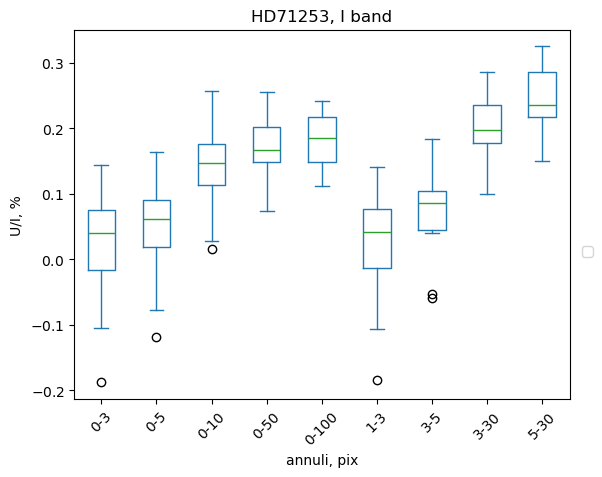

/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_74542/2599568955.py:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.4))


<Figure size 1200x400 with 0 Axes>

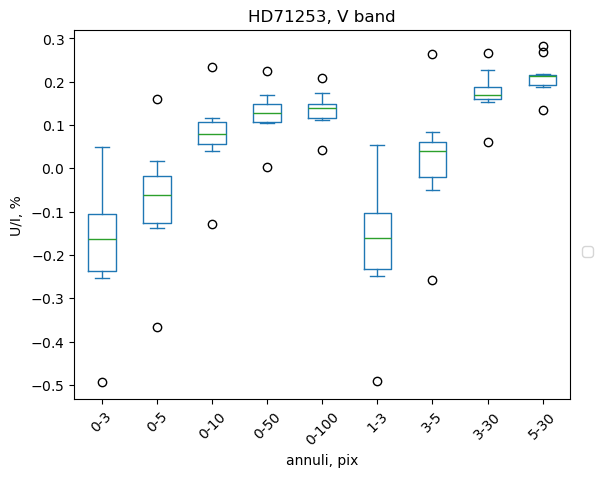

<Figure size 1200x400 with 0 Axes>

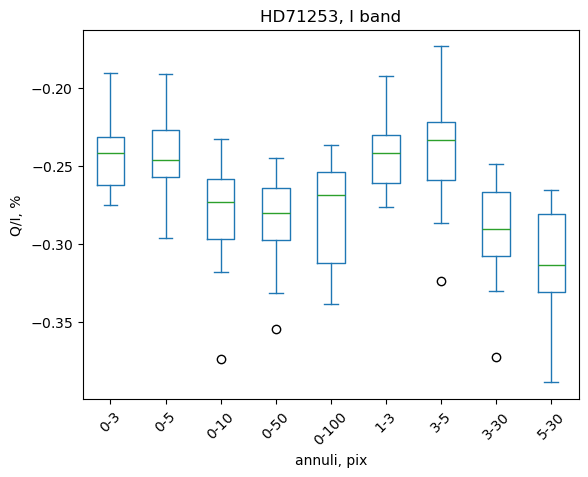

<Figure size 1200x400 with 0 Axes>

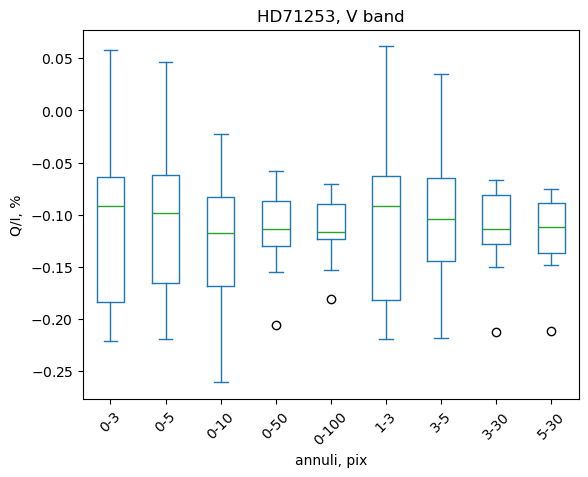

In [24]:
#plotting aperture photometry

for star in stars:

    if star=='AR_Pup':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/Ar_Pup' #For AR_Pup
        input_filename =dirdat+'AR_Pup_indiv_process_list.csv'

    elif star=='AR_Pup_dc_notnorm':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/Ar_Pup'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'

    elif star=='01.SCI_UMon':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/UMon'
        input_filename =dirdat+'process_list.csv'
        
    else:
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/'+star+'/'
        input_filename =dirdat+'process_list.csv'
        
    figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
    specific_folder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'   #dirdat+'quality/'
    #specific_folder=dirdat+'quality/'
    try:
    # Create target Directory
       os.mkdir(specific_folder)
    except FileExistsError:
        print("Directory " , specific_folder,  " already exists")
        
    output_filename = figfolder0+'no_unres_correction/'+star+'_V_Original_AP_per_cycle.txt'
    df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+'no_unres_correction/'+star+'_I_Original_AP_per_cycle.txt'
    df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
  
    output_filename = figfolder0+star+'_0-3_V_AP_per_cycle.txt'
    df_0_3_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+star+'_0-3_I_AP_per_cycle.txt'
    df_0_3_i = pd.read_csv(output_filename, delim_whitespace=True)

    # df_orig_v['cycle'] = pd.to_numeric(df_orig_v['cycle'], errors='coerce').fillna(0).astype(int)
    print(df_orig_v.columns.values)

    cycle_numbers = df_orig_v['cycle']
    current_labels = ['0-3', '0-5', '0-10', '0-50', '0-100', '1-3', '3-5', '3-30', '5-30']
    current_columnU = ['0-3_U/I[%]', '0-5_U/I[%]', '0-10_U/I[%]', '0-50_U/I[%]', '0-100_U/I[%]', '1-3_U/I[%]', '3-5_U/I[%]', '3-30_U/I[%]', '5-30_U/I[%]']
    current_columnQ = ['0-3_Q/I[%]', '0-5_Q/I[%]', '0-10_Q/I[%]', '0-50_Q/I[%]', '0-100_Q/I[%]', '1-3_Q/I[%]', '3-5_Q/I[%]', '3-30_Q/I[%]', '5-30_Q/I[%]']
    
    plt.figure(figsize=(12, 4))
    df_orig_i[current_columnU].plot(kind='box')
    positions = range(1, len(current_columnU) + 1)
    plt.xticks(positions, current_labels)
    plt.ylabel('U/I, %') 
    plt.xlabel('annuli, pix')
    plt.title(starnames[star] + ', I band')
    formatter = plt.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    ax = plt.subplot(111)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.4))
   
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.savefig(specific_folder + star + '_I_UI_annuli.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    plt.figure(figsize=(12, 4))
    # Plot each current data with the corresponding label and cycle numbers in the legend
    df_orig_v[current_columnU].plot(kind='box')
    plt.xticks(positions, current_labels)
    plt.ylabel('U/I, %')
    plt.xlabel('annuli, pix')
    plt.title(starnames[star] + ', V band')
    formatter = plt.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    ax = plt.subplot(111)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.4))
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.savefig(specific_folder + star + '_V_UI_annuli.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

    plt.figure(figsize=(12, 4))
    # Plot each current data with the corresponding label and cycle numbers in the legend
    df_orig_i[current_columnQ].plot(kind='box')
    plt.xticks(positions, current_labels)
    plt.ylabel('Q/I, %')
    plt.xlabel('annuli, pix')
    plt.title(starnames[star] + ', I band')
    formatter = plt.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.savefig(specific_folder + star + '_I_QI_annuli.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
    plt.figure(figsize=(12, 4))
    # Plot each current data with the corresponding label and cycle numbers in the legend
    df_orig_v[current_columnQ].plot(kind='box')
    plt.xticks(positions, current_labels)
    plt.xlabel('annuli, pix')
    plt.ylabel('Q/I, %')
    plt.title(starnames[star] + ', V band')
    formatter = plt.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.savefig(specific_folder + star + '_V_QI_annuli.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()


## Quality values for the data

In [25]:

for star in stars:

    figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
    
    specific_folder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
    # Create target Directory
    try:
        os.mkdir(specific_folder)
    except FileExistsError:
        print("Directory " , specific_folder,  " already exists")
        
    output_filename = figfolder0+'no_unres_correction/'+star+'_V_Original_AP_per_cycle.txt'
    df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+'no_unres_correction/'+star+'_I_Original_AP_per_cycle.txt'
    df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)
  
    #output_filename = dirdat+star+'_0-3_V_AP_per_cycle.txt'
    #df_0_3_v = pd.read_csv(output_filename, delim_whitespace=True)
    #output_filename = dirdat+star+'_0-3_I_AP_per_cycle.txt'
    #df_0_3_i = pd.read_csv(output_filename, delim_whitespace=True)
 
    #print(df_orig_v.head())
    print(star)
    print('V')
    print('median peak I normalised to total %.6f percents +- %.6f'%(np.median(df_orig_v['Peak_i(Strehl)']*100),np.std(df_orig_v['Peak_i(Strehl)']*100)))
    print('median CNT60 normalised to total %.6f percents +- %.6f'%(np.median(df_orig_v['CNT60[%]']),np.std(df_orig_v['CNT60[%]'])))
    
    print('median peak PI normalised to total I %.6f percents +- %.6f'%(np.median(df_orig_v['Peak_PI']*100),np.std(df_orig_v['Peak_PI']*100)))
    
    print('median FWHM %.3f mas +- %.3f'%(np.median(df_orig_v['FWHM']),np.std(df_orig_v['FWHM'])))
    print('ratio of FWHM %.3f  '%(np.max(df_orig_v['FWHM'])/np.min(df_orig_v['FWHM'])))
    
    print('I')
    print('median peak I normalised to total %.6f percents +- %.6f'%(np.median(df_orig_i['Peak_i(Strehl)']*100),np.std(df_orig_i['Peak_i(Strehl)']*100)))
    print('median CNT60 normalised to total %.6f percents +- %.6f'%(np.median(df_orig_i['CNT60[%]']),np.std(df_orig_i['CNT60[%]'])))
    
    print('median peak PI normalised to total I %.6f percents +- %.6f'%(np.median(df_orig_i['Peak_PI']*100),np.std(df_orig_i['Peak_PI']*100)))
    
    print('median FWHM %.3f mas +- %.3f'%(np.median(df_orig_i['FWHM']),np.std(df_orig_i['FWHM'])))
    print('ratio of FWHM %.3f  '%(np.max(df_orig_i['FWHM'])/np.min(df_orig_i['FWHM'])))
    
    

Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/REF_HD71253/Quality_indiv_cycles/  already exists
REF_HD71253
V
median peak I normalised to total 0.277500 percents +- 0.037371
median CNT60 normalised to total 0.084000 percents +- 0.013023
median peak PI normalised to total I 0.000914 percents +- 0.000197
median FWHM 31.944 mas +- 1.346
ratio of FWHM 1.142  
I
median peak I normalised to total 0.394000 percents +- 0.030735
median CNT60 normalised to total 0.002000 percents +- 0.000000
median peak PI normalised to total I 0.001273 percents +- 0.000139
median FWHM 30.306 mas +- 0.891
ratio of FWHM 1.089  


/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_74542/3034658899.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_74542/3034658899.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)


In [26]:
#stars=['IRAS08544-4431', 'IRAS08544-4431_dc_notnorm','AR_Pup','AR_Pup_dc_notnorm']
#stars=['HR4049_20190108','HR4049_20190107','HD71253','HD94680','HD96314','HD98025','V709_Car','HR4226','UMon_Katya']
# stars=['REF_HD71253']
# stars = ['01.SCI_UMon']

for star in stars:

    figfolder0='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'

    specific_folder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Quality_indiv_cycles/'
    # Create target Directory
    try:
        os.mkdir(specific_folder)
    except FileExistsError:
        print("Directory " , specific_folder,  " already exists")
        
    output_filename = figfolder0+'no_unres_correction/'+star+'_V_Original_AP_per_cycle.txt'
    df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
    output_filename = figfolder0+'no_unres_correction/'+star+'_I_Original_AP_per_cycle.txt'
    df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)

    # df_orig_v['cycle'] = pd.to_numeric(df_orig_v['cycle'], errors='coerce').fillna(0).astype(int)
    #print(df_orig_v.columns)
    print(df_orig_v.FWHM)
    

Directory  /Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/REF_HD71253/Quality_indiv_cycles/  already exists
0    29.314
1    29.518
2    30.661
3    31.503
4    31.782
5    32.389
6    32.106
7    32.746
8    33.484
9    32.985
Name: FWHM, dtype: float64


/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_74542/2912327420.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_v = pd.read_csv(output_filename, delim_whitespace=True)
/var/folders/xc/tr18j41x0lgdjpw201cfd6w00000gp/T/ipykernel_74542/2912327420.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig_i = pd.read_csv(output_filename, delim_whitespace=True)


## Number of counts per frame

In [27]:

for star in stars:
    #figfolder=dirdat+'original/'
    
    if star=='AR_Pup':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/AR_Pup/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_indiv_process_list.csv'
    elif star=='AR_Pup_dc_notnorm':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/AR_Pup/'  #For AR_Pup
        input_filename =dirdat+'AR_Pup_no_norm_indiv_process_list.csv'
    elif star=='01.SCI_UMon':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/UMon/'
        input_filename =dirdat+'process_list.csv'
        
    else:
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/spherediskanalysis/ZIMPOL_basic_red/'+starnames[star]+'/'
        input_filename =dirdat+'process_list.csv'

    table = pd.read_csv(input_filename)
    table['reference']= table['reference'].str.replace(' ', '_') #ix in case there are spaces in the name

    processes=table['id']

    reference={process:ref for process,ref in zip(table['id'], table['reference'])}


    #print(reference)
    print(star)
    for fittype in fittypes:
        #output_filename = dirdat+star+'_'+band[int(fittype)-1]+'_Original_AP_per_cycle.txt'
        print(band[int(fittype)-1])
        for process in processes:
            if star=='UMon':
                dirName=dirdat
                iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar_umon(dirName,process,fittype)
            else:        
                dirName=dirdat+'SPHERE_DC_DATA/'+str(process)+'/'
                iq,q,iu,u,i,q_phi,u_phi,pi,aolp,R,phi= load_and_make_polar(dirName,fittype)

            n=q.shape[0]

            iq_sum=np.sum(iq)
            iu_sum=np.sum(iu)
            pi_sum=np.sum(pi)
            print('sum of IQ %.2e, IU %.2e, PI %.2e' % (iq_sum, iu_sum, pi_sum))

REF_HD71253
V
sum of IQ 5.81e+06, IU 5.89e+06, PI 3.10e+05
sum of IQ 5.84e+06, IU 5.80e+06, PI 3.15e+05
sum of IQ 5.91e+06, IU 5.81e+06, PI 2.99e+05
sum of IQ 5.91e+06, IU 5.85e+06, PI 3.11e+05
sum of IQ 5.91e+06, IU 5.83e+06, PI 2.97e+05
sum of IQ 5.95e+06, IU 5.92e+06, PI 3.09e+05
sum of IQ 5.94e+06, IU 5.95e+06, PI 2.97e+05
sum of IQ 5.81e+06, IU 5.97e+06, PI 2.99e+05
sum of IQ 5.80e+06, IU 5.77e+06, PI 3.11e+05
sum of IQ 5.59e+06, IU 5.74e+06, PI 2.93e+05
I
sum of IQ 8.51e+05, IU 8.57e+05, PI 2.33e+05
sum of IQ 8.60e+05, IU 8.48e+05, PI 2.26e+05
sum of IQ 8.77e+05, IU 8.73e+05, PI 2.25e+05
sum of IQ 8.66e+05, IU 8.60e+05, PI 2.27e+05
sum of IQ 9.19e+05, IU 9.16e+05, PI 2.59e+05
sum of IQ 9.06e+05, IU 9.08e+05, PI 2.57e+05
sum of IQ 8.36e+05, IU 8.37e+05, PI 2.24e+05
sum of IQ 8.19e+05, IU 8.42e+05, PI 2.26e+05
sum of IQ 8.28e+05, IU 8.32e+05, PI 2.19e+05
sum of IQ 8.03e+05, IU 8.24e+05, PI 2.20e+05
